In [1]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import FinanceDataReader as fdr

import datetime as dt

import numpy as np

from tqdm import tqdm #진행바
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

# GPU
import tensorflow as tf

#https://www.tensorflow.org/guide/gpu#allowing_gpu_memory_growth
#프로세스의 요구량만큼 메모리 사용 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
#지정해서 쓰고 싶으면 model 쓸 때는 with 구문 안에 넣기

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
df = pd.read_csv('stock_2018_10days.csv')
# x = pd.read_csv('capstone_x.csv')
# # y = 

In [3]:
# x = df.iloc[:,:-1]
# y = df.iloc[:,-1]

In [4]:
# Next_Change 열 값 조건에 따라 변경
# 열 값은 왜 안바뀌는 가에 대하여...
# df[df.iloc[:,-1]>0.05].iloc[:,-1] = 1
# df[df.iloc[:,-1]<=0.05].iloc[:,-1] = 0
# df.iloc[:,-1]

# df[(df['Next_Change']>0.05)]['Next_Change'] = 1 
# df[(df['Next_Change']<=0.05)]['Next_Change'] = 0
# df

# 1 if df[df.iloc[:,-1]>0.05].iloc[:,-1] else 0

df.loc[(df.Next_Change>0.05),'Next_Change'] = 1
df.loc[(df.Next_Change<=0.05),'Next_Change'] = 0
df
# https://pongdangstory.tistory.com/518 한줄에 왜 안끝나?

,Code,Date,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_Volume,D-9_Trading_Value,D-9_Change,D-9_MA5,...,D-0_TSI,D-0_UO,D-0_SR,D-0_WR,D-0_AO,D-0_KAMA,D-0_ROC,D-0_PPO,D-0_PVO,Next_Change
0,50120,2018-01-15,10250,12050,10150,11800,26086769,307823874200,0.145631,10108.0,...,29.3225,45.3787,63.9228,-36.07720,3645.880000,11858.8,68.67470,12.32460,38.8520,0.0
1,50120,2018-01-16,11950,12450,10900,11750,20460474,240410569500,-0.004237,10538.0,...,28.0689,45.6406,53.2520,-46.74800,3980.740000,11947.6,47.78580,12.29020,30.6275,0.0
2,50120,2018-01-17,11850,14150,11600,12600,60663854,764364560400,0.072340,11232.0,...,22.3139,41.0354,25.8130,-74.18700,3687.650000,11946.2,13.10680,10.44330,23.7000,0.0
3,50120,2018-01-18,12800,13200,12000,12200,13935258,170010147600,-0.031746,11730.0,...,18.8794,41.3833,28.8725,-71.12750,2987.650000,11947.9,3.38983,9.22399,17.4172,0.0
4,50120,2018-01-19,12450,13400,12350,12850,16471707,211661434950,0.053279,12240.0,...,16.5383,33.5502,25.0000,-75.00000,2637.350000,11949.9,5.10638,8.26069,12.6972,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2532,11760,2018-05-15,21400,24100,20800,22400,1488904,33351449600,0.095354,20830.0,...,56.6722,68.0251,84.6369,-15.36310,6866.910000,27722.5,74.93730,13.01120,68.4751,0.0
2533,11760,2018-05-17,23500,23850,21950,22350,489326,10936436100,-0.064854,22040.0,...,54.5403,64.0099,85.1942,-14.80580,10338.970588,29517.6,83.12960,15.48880,67.1178,0.0
2534,11760,2018-06-07,41650,41900,37000,38800,1305256,50643932800,-0.058252,39190.0,...,29.5457,49.8274,70.6329,-29.36710,10088.100000,36598.8,11.81820,13.02900,17.8270,0.0
2535,11760,2018-06-11,40500,41300,40050,41300,712521,29427117300,0.298742,38620.0,...,31.8637,53.8917,95.8333,-4.16667,10979.700000,39093.7,20.87380,13.90680,19.4140,0.0


## 머신러닝 K-fold 교차 검증(cross validation)
데이터를 5-fold 교차검증으로 8개 모델을 학습하고 예측하여 평가한다.

### 1. Logistic Regression

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import time

results=[]
X = df.iloc[:,2:-1]
# X
y = df.iloc[:,-1]
# y
i=0
# skf = StratifiedKFold(n_splits=5)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # 학습  : test = 4 : 1 random split
for train_idx, test_idx in sss.split(X,y):
#     train_idx, test_idx
    x_train = df.iloc[train_idx,2:-1]
    y_train = df.iloc[train_idx,-1]
    x_test = df.iloc[test_idx,2:-1]
    y_test = df.iloc[test_idx,-1]
    # 1. Logistic regression    
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(max_iter=1000)
    start_time = time.time()
    _ = model.fit(x_train, y_train) # 학습
    
    training_time = time.time() - start_time
    
    y_pred_train = model.predict(x_train) 
    y_pred_test = model.predict(x_test) # 예측
    accuracy_train = accuracy_score(y_train, y_pred_train) # 설명변수 x_train에 대한 반응변수 y_train 예측의 정확도. 이미 학습할 때 사용한 데이터이므로 답을 아는 상태라 소용이 없다고 생각하면 됨.
    accuracy_test = accuracy_score(y_test, y_pred_test) # 학습에 사용하지 않은 설명변수 x_train에 대한 반응변수 y_test 예측의 정확도. 이게 늘 말하는 그 정확도임.
    results.append([i,'LogisticRegression',accuracy_train,accuracy_test, training_time])
    i+=1
results[-5:] # append 이미 되고있었구나,,, 그래서 뒤에서 5개만 뽑아서 보는거였구나,,,
# # 형태: i번째 학습, 학습 모델, train 정확도, test 정확도(최종정확도) 학습에 걸린 시간

[[0,
  'LogisticRegression',
  0.917200591424347,
  0.9173228346456693,
  0.014664888381958008],
 [1,
  'LogisticRegression',
  0.917200591424347,
  0.9173228346456693,
  0.01470327377319336],
 [2,
  'LogisticRegression',
  0.917200591424347,
  0.9173228346456693,
  0.012732505798339844],
 [3,
  'LogisticRegression',
  0.917200591424347,
  0.9173228346456693,
  0.014191389083862305],
 [4,
  'LogisticRegression',
  0.917200591424347,
  0.9173228346456693,
  0.014369010925292969]]

In [6]:
# results = np.array(results)
# results
# results.shape

# results[:,3] #test 정확도
# (results[:,3]).astype(float)
# np.mean((results[:,3]).astype(float))

# # cannot perform reduce with flexible type ; 숫자 아닌 애들로 수치연산 하려고 하면 발생하는 에러.
# # https://raisonde.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%97%90%EB%9F%AC-TypeError-cannot-perform-reduce-with-flexible-type

# # only size-1 arrays can be converted to Python scalars ; ndarray 안의 여러 값들을 int로 바꾸려할 때 발생하는 에러.
# # 해결책: x.astype(int)
# # https://www.statology.org/only-size-1-arrays-can-be-converted-to-python-scalars/
# # np.mean(list(results[:,3]))

### 2. Decision tree

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

X = df.iloc[:,2:-1]
y = df.iloc[:,-1]
i=0
# skf = StratifiedKFold(n_splits=5)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # 학습  : test = 4 : 1 random split
for train_idx, test_idx in sss.split(X,y):
    x_train = df.iloc[train_idx,2:-1]
    y_train = df.iloc[train_idx,-1]
    x_test = df.iloc[test_idx,2:-1]
    y_test = df.iloc[test_idx,-1]
    # 2. Decision tree
    from sklearn.tree import DecisionTreeClassifier
    model = DecisionTreeClassifier()
    start_time = time.time()    
    _ = model.fit(x_train, y_train)
    training_time = time.time() - start_time    
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    results.append([i,'DecisionTree',accuracy_train,accuracy_test, training_time])
    i+=1
results[-5:]
# results = np.array(results)
# np.mean((results[:,3]).astype(float))

[[0, 'DecisionTree', 1.0, 0.8385826771653543, 1.7125232219696045],
 [1, 'DecisionTree', 1.0, 0.8700787401574803, 1.564453363418579],
 [2, 'DecisionTree', 1.0, 0.8464566929133859, 1.2715952396392822],
 [3, 'DecisionTree', 1.0, 0.8346456692913385, 1.8232393264770508],
 [4, 'DecisionTree', 1.0, 0.8523622047244095, 1.343515396118164]]

### 3. Support vector machine

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

X = df.iloc[:,2:-1]
y = df.iloc[:,-1]
i=0
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # 학습  : test = 4 : 1 random split
for train_idx, test_idx in sss.split(X,y):
    x_train = df.iloc[train_idx,2:-1]
    y_train = df.iloc[train_idx,-1]
    x_test = df.iloc[test_idx,2:-1]
    y_test = df.iloc[test_idx,-1]
    # 3. Support vector machine
    from sklearn.svm import SVC
    model = SVC()
    start_time = time.time()
    _ = model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    results.append([i,'SupportVectorMachine',accuracy_train,accuracy_test, training_time])
    i+=1
results[-5:]
# results = np.array(results)
# np.mean((results[:,3]).astype(float))

[[0,
  'SupportVectorMachine',
  0.917200591424347,
  0.9173228346456693,
  0.12145638465881348],
 [1,
  'SupportVectorMachine',
  0.917200591424347,
  0.9173228346456693,
  0.13274025917053223],
 [2,
  'SupportVectorMachine',
  0.917200591424347,
  0.9173228346456693,
  0.13160395622253418],
 [3,
  'SupportVectorMachine',
  0.917200591424347,
  0.9173228346456693,
  0.12858223915100098],
 [4,
  'SupportVectorMachine',
  0.917200591424347,
  0.9173228346456693,
  0.13671040534973145]]

### 4. Gaussian naive bayes

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

X = df.iloc[:,2:-1]
y = df.iloc[:,-1]
i=0
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # 학습  : test = 4 : 1 random split
for train_idx, test_idx in sss.split(X,y):
    x_train = df.iloc[train_idx,2:-1]
    y_train = df.iloc[train_idx,-1]
    x_test = df.iloc[test_idx,2:-1]
    y_test = df.iloc[test_idx,-1]
    # 4. Gaussian naive bayes
    from sklearn.naive_bayes import GaussianNB
    model = GaussianNB()
    start_time = time.time()
    _ = model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    results.append([i,'GaussianNaiveBayes',accuracy_train,accuracy_test, training_time])    
    i+=1
results[-5:]

[[0,
  'GaussianNaiveBayes',
  0.24741251848201085,
  0.2440944881889764,
  0.01107645034790039],
 [1,
  'GaussianNaiveBayes',
  0.24987678659438148,
  0.234251968503937,
  0.010271072387695312],
 [2,
  'GaussianNaiveBayes',
  0.26367668802365696,
  0.2421259842519685,
  0.01108551025390625],
 [3,
  'GaussianNaiveBayes',
  0.25332676195170034,
  0.234251968503937,
  0.010239601135253906],
 [4,
  'GaussianNaiveBayes',
  0.2799408575653031,
  0.2952755905511811,
  0.011049270629882812]]

### 5. K nearest neighbor

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

X = df.iloc[:,2:-1]
y = df.iloc[:,-1]
i=0
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # 학습  : test = 4 : 1 random split
for train_idx, test_idx in sss.split(X,y):
    x_train = df.iloc[train_idx,2:-1]
    y_train = df.iloc[train_idx,-1]
    x_test = df.iloc[test_idx,2:-1]
    y_test = df.iloc[test_idx,-1]
    # 5. K nearest neighbor
    from sklearn.neighbors import KNeighborsClassifier
    model = KNeighborsClassifier()
    start_time = time.time()
    _ = model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    results.append([i,'KNearestNeighbor',accuracy_train,accuracy_test, training_time])
    i+=1
results[-5:]

[[0,
  'KNearestNeighbor',
  0.917200591424347,
  0.9133858267716536,
  0.00449061393737793],
 [1,
  'KNearestNeighbor',
  0.9181862986692952,
  0.9133858267716536,
  0.004859209060668945],
 [2,
  'KNearestNeighbor',
  0.9186791522917693,
  0.9114173228346457,
  0.005549430847167969],
 [3,
  'KNearestNeighbor',
  0.9157220305569246,
  0.9173228346456693,
  0.004946231842041016],
 [4,
  'KNearestNeighbor',
  0.9181862986692952,
  0.9133858267716536,
  0.005384922027587891]]

### 6. Random forest

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

X = df.iloc[:,2:-1]
y = df.iloc[:,-1]
i=0
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # 학습  : test = 4 : 1 random split
for train_idx, test_idx in sss.split(X,y):
    x_train = df.iloc[train_idx,2:-1]
    y_train = df.iloc[train_idx,-1]
    x_test = df.iloc[test_idx,2:-1]
    y_test = df.iloc[test_idx,-1]
    # 6. Random forest
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier()
    start_time = time.time()
    _ = model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    results.append([i,'RandomForest',accuracy_train,accuracy_test, training_time])
    i+=1
results[-5:]

[[0, 'RandomForest', 1.0, 0.9173228346456693, 2.6565990447998047],
 [1, 'RandomForest', 1.0, 0.9094488188976378, 2.7571887969970703],
 [2, 'RandomForest', 1.0, 0.9153543307086615, 2.573948621749878],
 [3, 'RandomForest', 1.0, 0.9153543307086615, 2.6287126541137695],
 [4, 'RandomForest', 1.0, 0.9153543307086615, 2.8593499660491943]]

### 7. Gradient boosing

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

X = df.iloc[:,2:-1]
y = df.iloc[:,-1]
i=0
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # 학습  : test = 4 : 1 random split
for train_idx, test_idx in sss.split(X,y):
    x_train = df.iloc[train_idx,2:-1]
    y_train = df.iloc[train_idx,-1]
    x_test = df.iloc[test_idx,2:-1]
    y_test = df.iloc[test_idx,-1]
    # 7. Gradient boosing
    from sklearn.ensemble import GradientBoostingClassifier
    model = GradientBoostingClassifier()
    start_time = time.time()
    _ = model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    results.append([i,'GradientBoosing',accuracy_train,accuracy_test, training_time])    
    i+=1
results[-5:]

[[0,
  'GradientBoosing',
  0.9546574667323805,
  0.9133858267716536,
  23.28597331047058],
 [1,
  'GradientBoosing',
  0.9659931000492854,
  0.9015748031496063,
  23.119247913360596],
 [2,
  'GradientBoosing',
  0.964514539181863,
  0.9133858267716536,
  23.153836011886597],
 [3,
  'GradientBoosing',
  0.9586002957121735,
  0.9133858267716536,
  23.213295936584473],
 [4,
  'GradientBoosing',
  0.9610645638245441,
  0.9035433070866141,
  23.39571475982666]]

### 8. Neural network

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

X = df.iloc[:,2:-1]
y = df.iloc[:,-1]
i=0
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # 학습  : test = 4 : 1 random split
for train_idx, test_idx in sss.split(X,y):
    x_train = df.iloc[train_idx,2:-1]
    y_train = df.iloc[train_idx,-1]
    x_test = df.iloc[test_idx,2:-1]
    y_test = df.iloc[test_idx,-1]
    # 8. Neural network
    from sklearn.neural_network import MLPClassifier
    model = MLPClassifier(max_iter=1000)
    start_time = time.time()
    _ = model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    results.append([i,'NeuralNetwork',accuracy_train,accuracy_test, training_time])    
    i+=1
results[-5:]

[[0,
  'NeuralNetwork',
  0.8634795465746673,
  0.8366141732283464,
  0.3602755069732666],
 [1,
  'NeuralNetwork',
  0.9152291769344505,
  0.8996062992125984,
  0.43476438522338867],
 [2,
  'NeuralNetwork',
  0.7644159684573681,
  0.7618110236220472,
  0.3411276340484619],
 [3,
  'NeuralNetwork',
  0.8521439132577624,
  0.844488188976378,
  0.3430194854736328],
 [4,
  'NeuralNetwork',
  0.8979793001478561,
  0.8307086614173228,
  1.4308857917785645]]

## 교차검증 결과 종합

In [16]:
df_results =pd.DataFrame(data=results, 
                columns= ['iter','method','accuracy_train','accuracy_test','training_time'])
df_results

,iter,method,accuracy_train,accuracy_test,training_time
0,0,LogisticRegression,0.917201,0.917323,0.014665
1,1,LogisticRegression,0.917201,0.917323,0.014703
2,2,LogisticRegression,0.917201,0.917323,0.012733
3,3,LogisticRegression,0.917201,0.917323,0.014191
4,4,LogisticRegression,0.917201,0.917323,0.014369
5,0,DecisionTree,1.000000,0.838583,1.712523
6,1,DecisionTree,1.000000,0.870079,1.564453
7,2,DecisionTree,1.000000,0.846457,1.271595
8,3,DecisionTree,1.000000,0.834646,1.823239
9,4,DecisionTree,1.000000,0.852362,1.343515


## 교차검증 결과 통계 계산

In [17]:
df_results.groupby('method').mean()

,iter,accuracy_train,accuracy_test,training_time
method,,,,
DecisionTree,2,1.000000,0.848425,1.543065
GaussianNaiveBayes,2,0.258847,0.250000,0.010744
GradientBoosing,2,0.960966,0.909055,23.233614
KNearestNeighbor,2,0.917595,0.913780,0.005046
LogisticRegression,2,0.917201,0.917323,0.014132
NeuralNetwork,2,0.858650,0.834646,0.582015
RandomForest,2,1.000000,0.914567,2.695160
SupportVectorMachine,2,0.917201,0.917323,0.130219


In [18]:
df_results.groupby('method').sem()

,iter,accuracy_train,accuracy_test,training_time
method,,,,
DecisionTree,0.707107,0.000000,0.006225,0.105163
GaussianNaiveBayes,0.707107,0.005958,0.011495,0.000200
GradientBoosing,0.707107,0.002040,0.002670,0.049434
KNearestNeighbor,0.707107,0.000526,0.000964,0.000190
LogisticRegression,0.707107,0.000000,0.000000,0.000363
NeuralNetwork,0.707107,0.026166,0.021956,0.212906
RandomForest,0.707107,0.000000,0.001335,0.050695
SupportVectorMachine,0.707107,0.000000,0.000000,0.002548


## 테스트 데이터셋 정확도 플랏

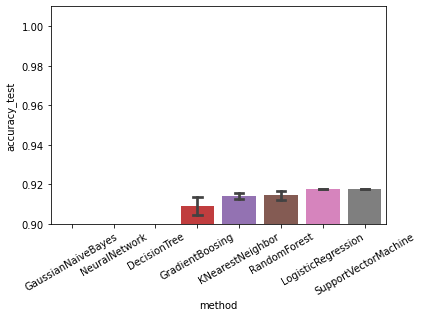

In [19]:
import seaborn as sns
ax = sns.barplot(x="method", y="accuracy_test", data=df_results, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('accuracy_test').index)
ax.set(ylim=(0.90, 1.01))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

## 훈련 데이터셋 정확도 플랏

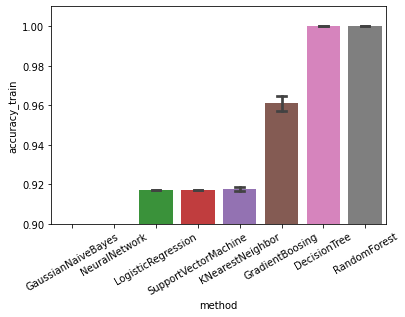

In [20]:
import seaborn as sns
ax = sns.barplot(x="method", y="accuracy_train", data=df_results, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('accuracy_train').index)
ax.set(ylim=(0.90, 1.01))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

## 훈련-테스트 데이터셋 정확도 플랏

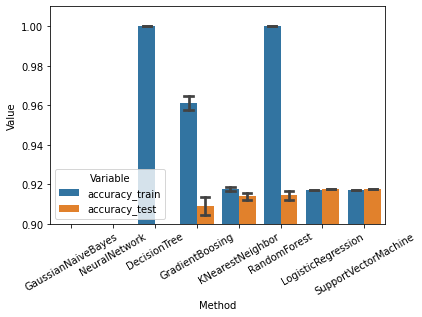

In [21]:
import seaborn as sns
tidy = df_results[['method', 'accuracy_train', 'accuracy_test']].melt(id_vars='method').rename(columns=str.title)
ax = sns.barplot(x="Method", y="Value", hue='Variable', data=tidy, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('accuracy_test').index)
ax.set(ylim=(0.90, 1.01))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

## 학습 시간 플랏

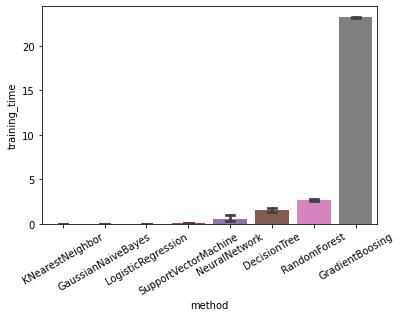

In [22]:
import seaborn as sns
ax = sns.barplot(x="method", y="training_time", data=df_results, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('training_time').index)
#ax.set(ylim=(0.90, 1.01))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);